In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import tqdm

In [2]:
!pip install gstools
import gstools as gs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.7/167.7 kB 10.5 MB/s eta 0:00:00


# Preliminaries

In this notebook we will work through the solution of inverse problems using machine learning techniques.

We assume to have a forward problem of the form
$$ A u + \epsilon = d $$
where $A$ is the forward operator, $u$ is the model, $\epsilon \sim N(0, \sigma^2 I)$ is the noise and $d$ is the observed data.
The goal is to recover $u$ from the noisy data $d$.

The first example is the borehole tomography where the each datum is
$$ d_i = \int_{{\rm ray}_i} u(x,z) d\ell  = \int_{\Omega} u(x,z)\, \delta(x-x(p_i),z-z(p_i)) dx\, dz$$
Here, $p_i$ is the ray path and $\delta$ is the Dirac delta function.

Below we generate the matrix $A$ for a collection of rays set on a mesh discretized by the vectors $x$ and $z$.





In [3]:
# Codes for the forward tomography problem
class tomography(nn.Module):

    def __init__(self, zs, ze, x, z):
      # rays start at (x[0], zs[i]) and end at (x[-1], ze[j])

        super().__init__()

        self.zs = zs
        self.ze = ze
        self.z  = z
        self.x  = x
        self.A = self.get_tomo_matrix(zs, ze, x, z)


    def get_ray(self, zs, ze, x, z):

        n = x.numel()
        X, Z = torch.meshgrid(x, z)


        s = (ze-zs)/(x[-1]-x[0])
        p = s*x + zs

        # Approximate the delta function over the path
        sigma = (x[1]-x[0])*2
        ray = torch.exp(-(X-x.unsqueeze(1))**2/sigma -(Z-p.unsqueeze(1))**2/sigma)
        ray[ray<0.1] = 0
        return ray

    def get_tomo_matrix(self, zs, ze, x, z):

        n = zs.numel()

        A = torch.zeros(0, x.numel()*z.numel())
        A = A.to_sparse()
        nrays = tqdm.trange(n)

        for i in nrays:
            ray = self.get_ray(zs[i], ze[i], x, z)
            ray = ray.reshape(1, -1)
            ray = ray.to_sparse()
            A = torch.cat((A,ray),dim=0)
            nrays.set_description('Percent computed: {:2f}'.format(100*i/n))

        return A

    def forward(self, u):
      return self.A@u.flatten()

    def adjoint(self, b):
      return self.A.t()@b.flatten()


In [4]:
# Generate a forward problem
# Generte the forward matrix
x = torch.linspace(0, 63, 64)
z = torch.linspace(0, 127, 128)

t = torch.linspace(0, 127, 65)
zs, ze = torch.meshgrid(t, t)
zs = zs.flatten()
ze = ze.flatten()

tomo = tomography(zs, ze, x, z)
print(' ')
print(' ')

print('Forward problem dim = ', tomo.A.shape)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Percent computed: 99.976331: 100%|██████████| 4225/4225 [00:53<00:00, 78.95it/s]

 
 
Forward problem dim =  torch.Size([4225, 8192])


Text(0.5, 1.0, 'A single ray')

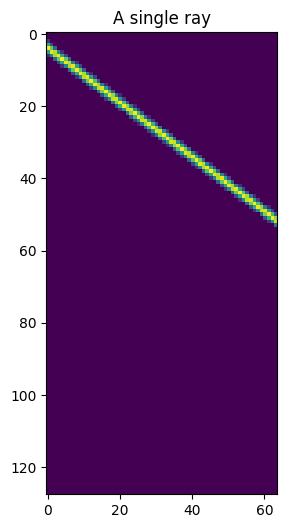

In [5]:
ray = tomo.get_ray(tomo.zs[156], tomo.ze[156], tomo.x, tomo.z)
plt.figure(1, figsize=[6,6])
plt.clf()
plt.imshow(ray.t())
plt.title('A single ray')

Text(0.5, 1.0, 'Ray Coverage')

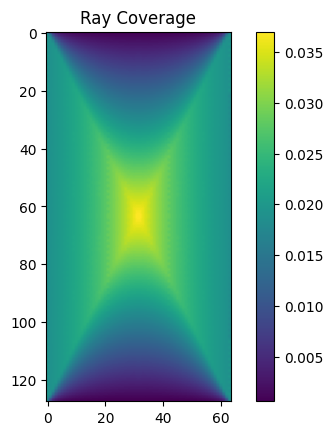

In [6]:
a = torch.mean(tomo.A.to_dense(), dim=0)
a = a.to_dense()
a = a.reshape(64, 128)
plt.imshow(a.t())
plt.colorbar()
plt.title('Ray Coverage')

Text(0.5, 1.0, 'The forward modeling matrix')

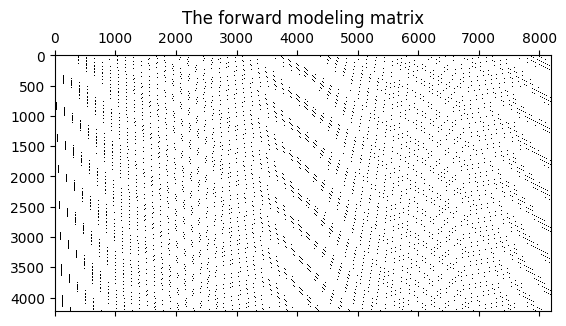

In [7]:
B = tomo.A.to_dense().numpy()
plt.spy(B)
plt.title('The forward modeling matrix')

In [ ]:
#UU, SS, VV = torch.svd(torch.tensor(B))
#plt.semilogy(torch.diag(SS))

**The Model Space**

When considering an inversion we need to think about potential models (more later). Let us start with a simple, non-realistic model.


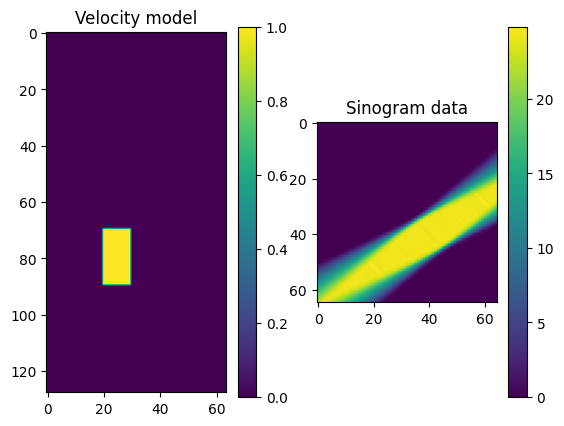

In [8]:
u = torch.zeros(64, 128)
u[20:30, 70:90] = 1.0

data = tomo(u)
plt.subplot(1, 2, 1)
plt.imshow(u.t())
plt.colorbar()
plt.title('Velocity model')
plt.subplot(1, 2, 2)
plt.imshow(data.reshape(65, 65))
plt.title('Sinogram data')
plt.colorbar()


Rather than using a very simplistic model space it is better to use some realistic one. Here we use models that are generated from a geostatistical package.

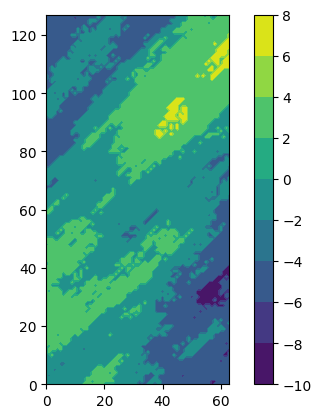

In [9]:
x = np.arange(64)
z = np.arange(128)

#model = gs.Gaussian(dim=2, var=0.4, len_scale=[9, 5], anis=0.9, angles=np.pi/8)
model = gs.Exponential(dim=2, var=9, len_scale=[90, 25], angles=np.pi/4)
srf = gs.SRF(model, mean=0)

srf.structured([x,z])
# Transform
values1 = np.linspace(np.min(srf.field), np.max(srf.field), 5)
u = srf.transform("discrete", store="f1", values=values1)
#u = srf.transform("zinnharvey", conn="high")
plt.contourf(x, z, u.transpose())
plt.axis('image')
plt.colorbar()

u = torch.tensor(u, dtype=torch.float32)
utrue = u.clone()


We can now use the forward model and the simulated model to generate some data we can try to invert

Noise level =  0.08281000703573227


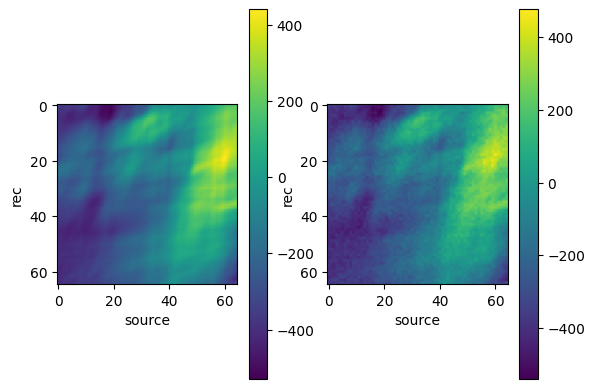

In [10]:
d = tomo(u)
plt.subplot(1,2,1)
plt.imshow(d.reshape(65,65))
plt.xlabel('source')
plt.ylabel('rec')
plt.colorbar()

# Add noise to the data
noise = torch.randn_like(d)
sig   = 20
dn = d + sig*noise
plt.subplot(1,2,2)
plt.imshow(dn.reshape(65, 65))
plt.xlabel('source')
plt.ylabel('rec')

plt.colorbar()

SNR = (dn-d).norm()/dn.norm()
print('Noise level = ', (SNR).item())

In [11]:
def steepest_descent(forProb, data, niter):

  r = data.clone()
  g = forProb.adjoint(r)
  u = 0
  for i in range(niter):

    Ag = forProb(g)
    mu = (Ag*r).mean()/(Ag*Ag).mean()
    u  = u + mu*g
    r  = r - mu*Ag
    g  = forProb.adjoint(r)
    print('%3d       %3.2e'%(i, r.norm()/data.norm()))
  return u

In [12]:
uhat = steepest_descent(tomo, dn, 20)

  0       5.68e-01
  1       3.82e-01
  2       2.83e-01
  3       2.26e-01
  4       1.92e-01
  5       1.70e-01
  6       1.54e-01
  7       1.43e-01
  8       1.34e-01
  9       1.27e-01
 10       1.21e-01
 11       1.17e-01
 12       1.13e-01
 13       1.09e-01
 14       1.06e-01
 15       1.04e-01
 16       1.01e-01
 17       9.92e-02
 18       9.73e-02
 19       9.56e-02


Recovery Error =  tensor(0.5369)


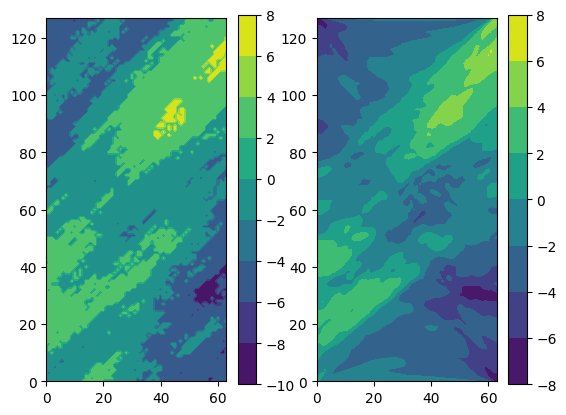

In [13]:
plt.subplot(1,2,1)
plt.contourf(x, z, utrue.reshape(64, 128).t())
plt.axis('image')
plt.colorbar()
plt.subplot(1,2,2)
plt.contourf(x, z, uhat.reshape(64, 128).t())
plt.axis('image')
plt.colorbar()

print('Recovery Error = ',(uhat.view(-1)-u.view(-1)).norm()/(u.view(-1)).norm())


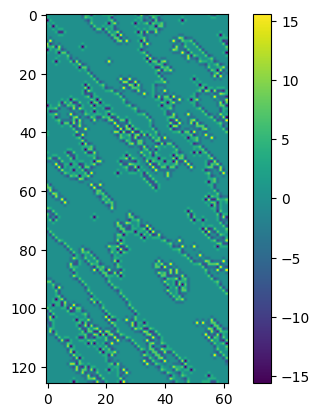

In [14]:
W = torch.tensor([[0,-1,0],[-1, 4, -1], [0, -1.0, 0]])
W  = W.reshape(1,1,3,3)
U2d = u.reshape(64, 128).t().unsqueeze(0).unsqueeze(0)
Q = F.conv2d(U2d, W)
plt.imshow(Q.squeeze())
plt.colorbar()


In [15]:
# Codes for the forward tomography problem
class regularization(nn.Module):

    def __init__(self, nx, nz):

        super().__init__()

        self.nx = nx
        self.nz = nz
        W = torch.tensor([[-2,-1,-2],[-1, 12, -1], [-2, -1.0, -2]])
        self.W  = W.reshape(1,1,3,3)


    def forward(self, u):


      u = u.reshape(1,1,self.nx,self.nz)
      Wu = F.conv2d(u, self.W)
      WTWu = F.conv_transpose2d(Wu, self.W)
      return 0.5*(Wu).norm()**2, WTWu


#Reg = regularization(64, 128)

#u = torch.randn(64*128)
#out, Hw = Reg(u)

#print(out, Hw.shape)





In [17]:
def conjugate_gradient(forProb, reg, alpha, d, niter=10, tol=1e-3):

  def HmatVec(x, forProb, reg, alpha):
    Ax = forProb(x)
    ATAx = forProb.adjoint(Ax)
    _, WTWx = reg(x)
    Hx = ATAx + alpha*(WTWx).view(-1)
    return Hx

  rhs = forProb.adjoint(d)
  u   = 0
  r   = rhs.clone()

  p   = r.clone()
  for i in range(niter):
    Hp = HmatVec(p, forProb, reg, alpha)
    rsq = (r*r).mean()
    mu = (r*r).mean()/(p*Hp).mean()
    u = u + mu*p
    r = r - mu*Hp

    if r.norm()/rhs.norm() < tol:
      return u

    beta = (r*r).mean()/rsq
    p    = r + beta*p
    misfit = (forProb(u) - d).norm()/d.norm()
    print('%3d      %3.2e      %3.2e'%(i, r.norm()/rhs.norm(), misfit))
  return u

In [38]:
reg = regularization(64, 128)
uReg = conjugate_gradient(tomo, reg, 1e2, dn, niter=100, tol=1e-5)

  0      4.80e-01      5.68e-01
  1      2.04e-01      2.89e-01
  2      1.33e-01      1.95e-01
  3      1.02e-01      1.81e-01
  4      9.11e-02      1.42e-01
  5      5.18e-02      1.36e-01
  6      6.34e-02      1.24e-01
  7      4.33e-02      1.14e-01
  8      2.99e-02      1.12e-01
  9      4.39e-02      1.05e-01
 10      2.95e-02      1.01e-01
 11      2.12e-02      9.97e-02
 12      2.51e-02      9.77e-02
 13      2.30e-02      9.60e-02
 14      1.81e-02      9.52e-02
 15      1.73e-02      9.43e-02
 16      1.48e-02      9.37e-02
 17      1.33e-02      9.33e-02
 18      1.41e-02      9.28e-02
 19      1.15e-02      9.24e-02
 20      9.13e-03      9.22e-02
 21      9.68e-03      9.19e-02
 22      1.01e-02      9.15e-02
 23      7.83e-03      9.13e-02
 24      7.36e-03      9.11e-02
 25      7.92e-03      9.09e-02
 26      6.99e-03      9.07e-02
 27      6.08e-03      9.06e-02
 28      6.08e-03      9.05e-02
 29      6.50e-03      9.04e-02
 30      5.64e-03      9.03e-02
 31     

Recovery Error =  tensor(0.4849)
Recovery Error =  tensor(0.5369)


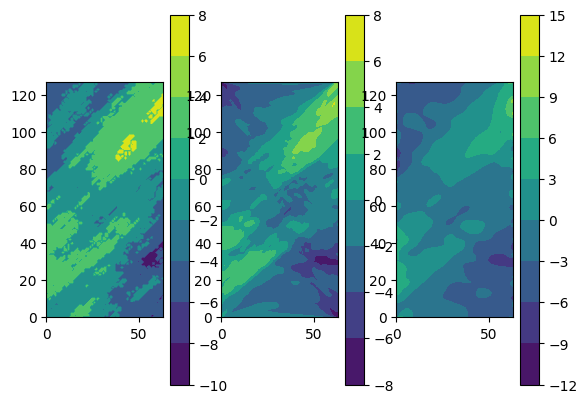

In [39]:
plt.subplot(1,3,1)
plt.contourf(x, z, utrue.reshape(64, 128).t())
plt.axis('image')
plt.colorbar()
plt.subplot(1,3,2)
plt.contourf(x, z, uhat.reshape(64, 128).t())
plt.axis('image')
plt.colorbar()
plt.subplot(1,3,3)
plt.contourf(x, z, uReg.reshape(64, 128).t())
plt.axis('image')
plt.colorbar()

print('Recovery Error = ',(uReg.view(-1)-utrue.view(-1)).norm()/(utrue.view(-1)).norm())
print('Recovery Error = ',(uhat.view(-1)-utrue.view(-1)).norm()/(utrue.view(-1)).norm())



In [18]:
class SL1regularization(nn.Module):

    def __init__(self, nx=64, nz=128, nhid=16):

        super().__init__()

        self.nx = nx
        self.nz = nz
        self.W = nn.Parameter(torch.rand(nhid, 1, 5, 5))
        #self.W = nn.Conv2d(1, nhid, kernel_size=5)


    def forward(self, u):

      u = u.reshape(1,1,self.nx,self.nz)
      Wu = F.conv2d(u, self.W) #
      phi = torch.log(torch.cosh(Wu))
      Wu  = torch.tanh(Wu)
      phi_u = F.conv_transpose2d(Wu, self.W)
      return phi.mean(), phi_u


In [40]:
class inet(nn.Module):

    def __init__(self, reg, forProb, nx=64, nz=128, niter=8):

        super().__init__()

        self.reg     = reg
        self.forProb = forProb
        self.niter   = niter
        self.nx = nx
        self.nz = nz
        self.niter = niter
        self.alpha = 0.01


    def forward(self, d):

      u = 1e-3*self.forProb.adjoint(d)
      u = u.reshape(1,1,self.nx,self.nz)

      for i in range(self.niter):

        Au = self.forProb(u)
        r  = Au - d
        #print('%3d    %3.2e'%(i, r.norm()/d.norm()))
        g_data = self.forProb.adjoint(r)
        Ag = self.forProb(g_data)
        mu = (Ag*r).mean()/(Ag*Ag).mean()

        # mu compute with opimal direction
        g_data = g_data.reshape(u.shape[0], u.shape[1], u.shape[2], u.shape[3])
        u = u - mu*g_data

        # update regularization
        phi, g_phi = self.reg(u)
        u = u - self.alpha*g_phi

      return u



In [41]:
reg = SL1regularization(nhid=16)
net = inet(reg, tomo, niter=5)
print('Number of parameters = ',sum([p.numel() for p in net.parameters()]))


uR = net(dn)

Number of parameters =  400


Recovery Error =  tensor(0.4849)
Recovery Error =  tensor(0.5369)
Recovery Error =  tensor(0.9924, grad_fn=<DivBackward0>)


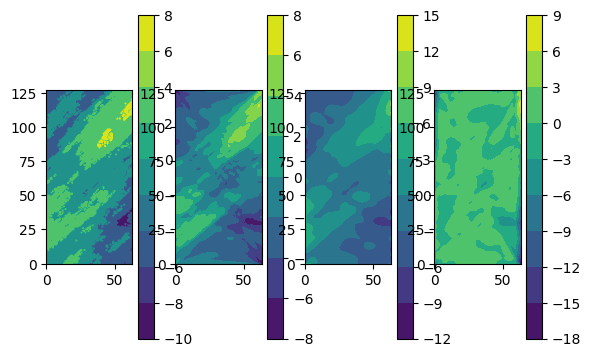

In [42]:
plt.subplot(1,4,1)
plt.contourf(x, z, utrue.reshape(64, 128).t())
plt.axis('image')
plt.colorbar()
plt.subplot(1,4,2)
plt.contourf(x, z, uhat.reshape(64, 128).t())
plt.axis('image')
plt.colorbar()
plt.subplot(1,4,3)
plt.contourf(x, z, uReg.reshape(64, 128).t())
plt.axis('image')
plt.colorbar()
plt.subplot(1,4,4)
plt.contourf(x, z, uR.detach().reshape(64, 128).t())
plt.axis('image')
plt.colorbar()

print('Recovery Error = ',(uReg.view(-1)-utrue.view(-1)).norm()/(utrue.view(-1)).norm())
print('Recovery Error = ',(uhat.view(-1)-utrue.view(-1)).norm()/(utrue.view(-1)).norm())
print('Recovery Error = ',(uR.view(-1)-utrue.view(-1)).norm()/(utrue.view(-1)).norm())



In [ ]:
# training the network
optim = Adam(net.parameters(), lr=1e-2)

n_epochs = 50

for i in range(n_epochs):

  optim.zero_grad()
  uR = net(dn)

  loss = F.mse_loss(uR.view(-1), utrue.view(-1))/F.mse_loss(torch.zeros_like(utrue), utrue)
  print('%3d    %3.2e'%(i, loss))
  loss.backward()
  torch.nn.utils.clip_grad_norm_(parameters=net.parameters(), max_norm=0.6, norm_type=2.0)
  optim.step()




  0    8.75e-01
  1    8.50e-01
  2    8.28e-01
  3    8.08e-01
  4    7.84e-01
  5    7.62e-01
  6    7.44e-01
  7    7.27e-01
  8    7.10e-01
  9    6.92e-01
 10    6.72e-01
 11    6.51e-01
 12    6.35e-01
 13    6.17e-01
 14    6.00e-01
 15    5.83e-01
 16    5.67e-01
 17    5.51e-01
 18    5.36e-01
 19    5.20e-01
 20    5.05e-01
 21    4.90e-01
 22    4.76e-01
 23    4.63e-01
 24    4.50e-01
 25    4.38e-01
 26    4.27e-01
 27    4.16e-01
 28    4.06e-01
 29    3.96e-01
 30    3.88e-01
 31    3.79e-01
 32    3.71e-01
 33    3.63e-01
 34    3.54e-01
 35    3.46e-01
 36    3.38e-01
 37    3.29e-01
 38    3.21e-01
 39    3.13e-01
 40    3.07e-01
 41    3.00e-01
 42    2.95e-01
 43    2.90e-01
 44    2.85e-01
 45    2.81e-01
 46    2.76e-01
 47    2.72e-01
 48    2.68e-01
 49    2.64e-01


Recovery Error =  tensor(0.4573)
Recovery Error =  tensor(0.4560)
Recovery Error =  tensor(0.5102, grad_fn=<DivBackward0>)


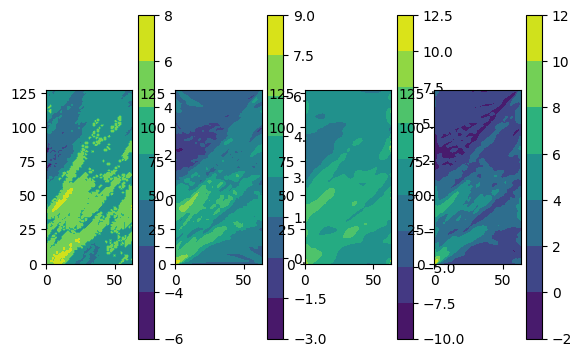

In [ ]:
uR = net(dn)
plt.subplot(1,4,1)
plt.contourf(x, z, utrue.reshape(64, 128).t())
plt.axis('image')
plt.colorbar()
plt.subplot(1,4,2)
plt.contourf(x, z, uhat.reshape(64, 128).t())
plt.axis('image')
plt.colorbar()
plt.subplot(1,4,3)
plt.contourf(x, z, uReg.reshape(64, 128).t())
plt.axis('image')
plt.colorbar()
plt.subplot(1,4,4)
plt.contourf(x, z, uR.detach().reshape(64, 128).t())
plt.axis('image')
plt.colorbar()

print('Recovery Error = ',(uReg.view(-1)-utrue.view(-1)).norm()/(utrue.view(-1)).norm())
print('Recovery Error = ',(uhat.view(-1)-utrue.view(-1)).norm()/(utrue.view(-1)).norm())
print('Recovery Error = ',(uR.view(-1)-utrue.view(-1)).norm()/(utrue.view(-1)).norm())



In [21]:
class inet_uroll(nn.Module):

    def __init__(self, forProb, nhid=16, nx=64, nz=128, niter=8):

        super().__init__()

        reg = nn.ParameterList()
        for i in range(niter):
          regi = SL1regularization(nhid=16)
          reg.append(regi)

        self.reg     = reg
        self.forProb = forProb
        self.niter   = niter
        self.nx = nx
        self.nz = nz
        self.niter = niter
        self.alpha = 0.01


    def forward(self, d):

      u = 1e-3*self.forProb.adjoint(d)
      u = u.reshape(1,1,self.nx,self.nz)

      for i in range(self.niter):

        Au = self.forProb(u)
        r  = Au - d
        #print('%3d    %3.2e'%(i, r.norm()/d.norm()))
        g_data = self.forProb.adjoint(r)
        Ag = self.forProb(g_data)
        mu = (Ag*r).mean()/(Ag*Ag).mean()

        # mu compute with opimal direction
        g_data = g_data.reshape(u.shape[0], u.shape[1], u.shape[2], u.shape[3])
        u = u - mu*g_data

        # update regularization
        phi, g_phi = self.reg[i](u)
        u = u - self.alpha*g_phi

      return u



In [ ]:
net = inet_uroll(tomo, niter=5)
print('Number of parameters = ',sum([p.numel() for p in net.parameters()]))


Number of parameters =  2000


In [ ]:
# training the network
optim = Adam(net.parameters(), lr=1e-2)

n_epochs = 50

for i in range(n_epochs):

  optim.zero_grad()
  uR = net(dn)

  loss = F.mse_loss(uR.view(-1), utrue.view(-1))/F.mse_loss(torch.zeros_like(utrue), utrue)
  print('%3d    %3.2e'%(i, loss))
  loss.backward()
  torch.nn.utils.clip_grad_norm_(parameters=net.parameters(), max_norm=0.6, norm_type=2.0)
  optim.step()

  0    8.88e-01
  1    8.62e-01
  2    8.37e-01
  3    8.10e-01
  4    7.81e-01
  5    7.60e-01
  6    7.41e-01
  7    7.26e-01
  8    7.11e-01
  9    6.97e-01
 10    6.82e-01
 11    6.69e-01
 12    6.58e-01
 13    6.46e-01
 14    6.34e-01
 15    6.23e-01
 16    6.11e-01
 17    5.99e-01
 18    5.89e-01
 19    5.79e-01
 20    5.69e-01
 21    5.58e-01
 22    5.48e-01
 23    5.37e-01
 24    5.27e-01
 25    5.17e-01
 26    5.06e-01
 27    4.96e-01
 28    4.85e-01
 29    4.75e-01
 30    4.65e-01
 31    4.55e-01
 32    4.44e-01
 33    4.34e-01
 34    4.25e-01
 35    4.16e-01
 36    4.08e-01
 37    3.99e-01
 38    3.90e-01
 39    3.82e-01
 40    3.75e-01
 41    3.67e-01
 42    3.60e-01
 43    3.53e-01
 44    3.46e-01
 45    3.39e-01
 46    3.33e-01
 47    3.27e-01
 48    3.21e-01
 49    3.15e-01


In [ ]:
class resnet(nn.Module):

    def __init__(self, nhid=64, nlayers=3):

        super().__init__()


        self.nhid    = nhid
        self.nlayers = nlayers
        self.Kopen   = nn.Conv2d(1, nhid, kernel_size=1)
        self.K1       = nn.Parameter(1e-3*torch.randn(nlayers, nhid, nhid, 3, 3))
        self.K2       = nn.Parameter(1e-3*torch.randn(nlayers, nhid, nhid, 3, 3))
        self.Kclose   = nn.Conv2d(nhid, 1, kernel_size=1)


    def forward(self, u):

      u = self.Kopen(u)
      for i in range(self.nlayers):
        du = F.conv2d(u, self.K1[i], padding=1)
        du = F.leaky_relu(du, negative_slope=0.2)
        du = F.conv2d(du, self.K2[i], padding=1)

        u = u + du

      u = self.Kclose(u)

      return u

In [ ]:
net = resnet()
uout = net(u.reshape(1, 1, 64, 128))

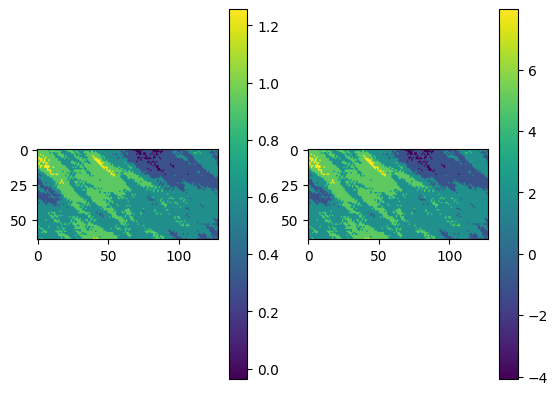

In [ ]:
plt.subplot(1,2,1)
plt.imshow(uout[0,0,:,:].detach().cpu())
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(u[:,:].detach().cpu())
plt.colorbar()

In [ ]:
class inet_res(nn.Module):

    def __init__(self, forProb, nhid=64, nx=64, nz=128, niter=8):

        super().__init__()

        reg = nn.ParameterList()
        for i in range(niter):
          regi = resnet(nhid=nhid)
          reg.append(regi)
        self.reg     = reg
        self.forProb = forProb
        self.niter   = niter
        self.nx = nx
        self.nz = nz
        self.niter = niter
        self.alpha = 0.01


    def forward(self, d):

      u = 1e-3*self.forProb.adjoint(d)
      u = u.reshape(1,1,self.nx,self.nz)

      for i in range(self.niter):

        Au = self.forProb(u)
        r  = Au - d
        #print('%3d    %3.2e'%(i, r.norm()/d.norm()))
        g_data = self.forProb.adjoint(r)
        Ag = self.forProb(g_data)
        mu = (Ag*r).mean()/(Ag*Ag).mean()

        # mu compute with opimal direction
        g_data = g_data.reshape(u.shape[0], u.shape[1], u.shape[2], u.shape[3])
        u = u - mu*g_data

        # update regularization
        s = self.reg[i](u)
        u = u - self.alpha*s

      return u



In [ ]:
# training the network
net = inet_res(tomo)
print('Number of parameters = ',sum([p.numel() for p in net.parameters()]))

optim = Adam(net.parameters(), lr=1e-4)

n_epochs = 150

for i in range(n_epochs):

  optim.zero_grad()
  uR = net(dn)

  loss = F.mse_loss(uR.view(-1), utrue.view(-1))/F.mse_loss(torch.zeros_like(utrue), utrue)
  print('%3d    %3.2e'%(i, loss))
  loss.backward()
  torch.nn.utils.clip_grad_norm_(parameters=net.parameters(), max_norm=0.6, norm_type=2.0)
  optim.step()

Number of parameters =  1771016
  0    2.11e-01
  1    2.11e-01
  2    2.11e-01
  3    2.11e-01
  4    2.11e-01
  5    2.11e-01
  6    2.10e-01
  7    2.10e-01
  8    2.09e-01
  9    2.08e-01
 10    2.07e-01
 11    2.07e-01
 12    2.07e-01
 13    2.06e-01
 14    2.07e-01
 15    2.06e-01
 16    2.06e-01
 17    2.05e-01
 18    2.04e-01
 19    2.04e-01
 20    2.03e-01
 21    2.03e-01
 22    2.02e-01
 23    2.02e-01
 24    2.01e-01
 25    2.00e-01
 26    1.99e-01
 27    1.98e-01
 28    1.97e-01
 29    1.96e-01
 30    1.95e-01
 31    1.94e-01
 32    1.93e-01
 33    1.92e-01
 34    1.90e-01
 35    1.89e-01
 36    1.88e-01
 37    1.87e-01
 38    1.86e-01
 39    1.85e-01
 40    1.84e-01
 41    1.83e-01
 42    1.82e-01
 43    1.81e-01
 44    1.81e-01
 45    1.81e-01
 46    1.81e-01
 47    1.80e-01
 48    1.79e-01
 49    1.79e-01
 50    1.79e-01
 51    1.78e-01
 52    1.78e-01
 53    1.78e-01
 54    1.78e-01
 55    1.78e-01
 56    1.77e-01
 57    1.77e-01
 58    1.77e-01
 59    1.77e-01
 60    1

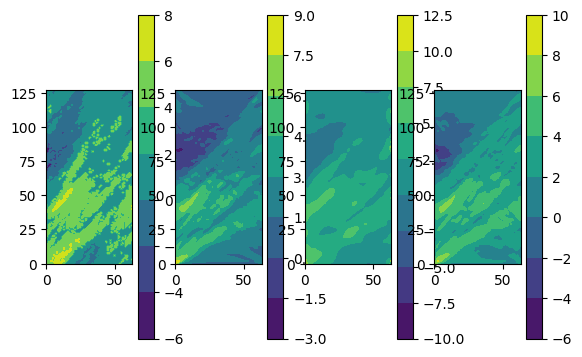

In [ ]:
plt.subplot(1,4,1)
plt.contourf(x, z, utrue.reshape(64, 128).t())
plt.axis('image')
plt.colorbar()
plt.subplot(1,4,2)
plt.contourf(x, z, uhat.reshape(64, 128).t())
plt.axis('image')
plt.colorbar()
plt.subplot(1,4,3)
plt.contourf(x, z, uReg.reshape(64, 128).t())
plt.axis('image')
plt.colorbar()
plt.subplot(1,4,4)
plt.contourf(x, z, uR.detach().reshape(64, 128).t())
plt.axis('image')
plt.colorbar()


In [35]:
class unet(nn.Module):

    def __init__(self, forProb, nhid=16, nx=64, nz=128, niter=32):

        super().__init__()

        self.forProb = forProb
        self.niter   = niter
        self.nx = nx
        self.nz = nz
        self.niter = niter

        self.down1 = nn.Conv2d(1, nhid, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(nhid)
        self.relu1 = nn.ReLU()

        self.down2 = nn.Conv2d(nhid, nhid*2, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(nhid*2)
        self.relu2 = nn.ReLU()

        self.down3 = nn.Conv2d(nhid*2, nhid*4, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(nhid*4)
        self.relu3 = nn.ReLU()

        self.down4 = nn.Conv2d(nhid*4, nhid*8, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(nhid*8)
        self.relu4 = nn.ReLU()

        self.up1 = nn.ConvTranspose2d(nhid*8, nhid*4, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(nhid*4)
        self.relu5 = nn.ReLU()

        self.up2 = nn.ConvTranspose2d(nhid*4, nhid*2, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn6 = nn.BatchNorm2d(nhid*2)
        self.relu6 = nn.ReLU()

        self.up3 = nn.ConvTranspose2d(nhid*2, nhid, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn7 = nn.BatchNorm2d(nhid)
        self.relu7 = nn.ReLU()

        self.up4 = nn.ConvTranspose2d(nhid, 1, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn8 = nn.BatchNorm2d(1)
        self.relu8 = nn.ReLU()


    def forward(self, d):

      u = 1e-3*self.forProb.adjoint(d)
      u = u.reshape(1,1,self.nx,self.nz)

      u1 = self.down1(u)
      u1 = self.bn1(u1)
      u1 = self.relu1(u1)

      u2 = self.down2(u1)
      u2 = self.bn2(u2)
      u2 = self.relu2(u2)

      u3 = self.down3(u2)
      u3 = self.bn3(u3)
      u3 = self.relu3(u3)

      u4 = self.down4(u3)
      u4 = self.bn4(u4)
      u4 = self.relu4(u4)

      u5 = self.up1(u4)
      u5 = self.bn5(u5)
      u5 = self.relu5(u5)

      u6 = self.up2(u5)
      u6 = self.bn6(u6)
      u6 = self.relu6(u6)

      u7 = self.up3(u6)
      u7 = self.bn7(u7)
      u7 = self.relu7(u7)

      u8 = self.up4(u7)
      u8 = self.bn8(u8)
      u8 = self.relu8(u8)

      return u8



In [36]:
# training the network
net = unet(tomo)
print('Number of parameters = ',sum([p.numel() for p in net.parameters()]))

optim = Adam(net.parameters(), lr=1e-4)

n_epochs = 150

for i in range(n_epochs):

  optim.zero_grad()
  uR = net(dn)

  loss = F.mse_loss(uR.view(-1), utrue.view(-1))/F.mse_loss(torch.zeros_like(utrue), utrue)
  print('%3d    %3.2e'%(i, loss))
  loss.backward()
  torch.nn.utils.clip_grad_norm_(parameters=net.parameters(), max_norm=0.6, norm_type=2.0)
  optim.step()

Number of parameters =  194530
  0    1.10e+00
  1    1.08e+00
  2    1.07e+00
  3    1.05e+00
  4    1.04e+00
  5    1.03e+00
  6    1.02e+00
  7    1.01e+00
  8    1.01e+00
  9    9.98e-01
 10    9.92e-01
 11    9.86e-01
 12    9.81e-01
 13    9.76e-01
 14    9.71e-01
 15    9.67e-01
 16    9.63e-01
 17    9.59e-01
 18    9.55e-01
 19    9.52e-01
 20    9.49e-01
 21    9.46e-01
 22    9.44e-01
 23    9.41e-01
 24    9.39e-01
 25    9.36e-01
 26    9.34e-01
 27    9.32e-01
 28    9.30e-01
 29    9.28e-01
 30    9.27e-01
 31    9.25e-01
 32    9.23e-01
 33    9.21e-01
 34    9.20e-01
 35    9.18e-01
 36    9.17e-01
 37    9.15e-01
 38    9.14e-01
 39    9.12e-01
 40    9.11e-01
 41    9.10e-01
 42    9.08e-01
 43    9.07e-01
 44    9.06e-01
 45    9.04e-01
 46    9.03e-01
 47    9.02e-01
 48    9.00e-01
 49    8.99e-01
 50    8.98e-01
 51    8.97e-01
 52    8.96e-01
 53    8.95e-01
 54    8.94e-01
 55    8.93e-01
 56    8.92e-01
 57    8.91e-01
 58    8.90e-01
 59    8.89e-01
 60    8.

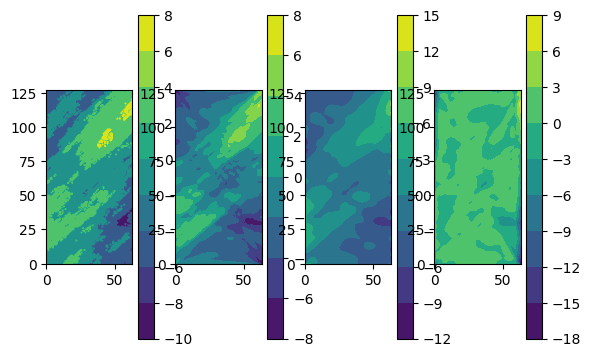

In [43]:
plt.subplot(1,4,1)
plt.contourf(x, z, utrue.reshape(64, 128).t())
plt.axis('image')
plt.colorbar()
plt.subplot(1,4,2)
plt.contourf(x, z, uhat.reshape(64, 128).t())
plt.axis('image')
plt.colorbar()
plt.subplot(1,4,3)
plt.contourf(x, z, uReg.reshape(64, 128).t())
plt.axis('image')
plt.colorbar()
plt.subplot(1,4,4)
plt.contourf(x, z, uR.detach().reshape(64, 128).t())
plt.axis('image')
plt.colorbar()

In [44]:
class resnet(nn.Module):

    def __init__(self, forProb, nhid=64, nx=64, nz=128, niter=32):

        super().__init__()

        self.forProb = forProb
        self.niter   = niter
        self.nx = nx
        self.nz = nz
        self.niter = niter

        self.down1 = nn.Conv2d(1, nhid, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(nhid)
        self.relu1 = nn.ReLU()

        self.down2 = nn.Conv2d(nhid, nhid*2, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(nhid*2)
        self.relu2 = nn.ReLU()

        self.down3 = nn.Conv2d(nhid*2, nhid*4, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(nhid*4)
        self.relu3 = nn.ReLU()

        self.down4 = nn.Conv2d(nhid*4, nhid*8, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(nhid*8)
        self.relu4 = nn.ReLU()

        self.up1 = nn.ConvTranspose2d(nhid*8, nhid*4, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(nhid*4)
        self.relu5 = nn.ReLU()

        self.up2 = nn.ConvTranspose2d(nhid*4, nhid*2, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn6 = nn.BatchNorm2d(nhid*2)
        self.relu6 = nn.ReLU()

        self.up3 = nn.ConvTranspose2d(nhid*2, nhid, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn7 = nn.BatchNorm2d(nhid)
        self.relu7 = nn.ReLU()

        self.up4 = nn.ConvTranspose2d(nhid, 1, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn8 = nn.BatchNorm2d(1)
        self.relu8 = nn.ReLU()


    def forward(self, d):

      u = 1e-3*self.forProb.adjoint(d)
      u = u.reshape(1,1,self.nx,self.nz)

      u1 = self.down1(u)
      u1 = self.bn1(u1)
      u1 = self.relu1(u1)

      u2 = self.down2(u1)
      u2 = self.bn2(u2)
      u2 = self.relu2(u2)

      u3 = self.down3(u2)
      u3 = self.bn3(u3)
      u3 = self.relu3(u3)

      u4 = self.down4(u3)
      u4 = self.bn4(u4)
      u4 = self.relu4(u4)

      u5 = self.up1(u4)
      u5 = self.bn5(u5)
      u5 = self.relu5(u5)

      u6 = self.up2(u5)
      u6 = self.bn6(u6)
      u6 = self.relu6(u6)

      u7 = self.up3(u6)
      u7 = self.bn7(u7)
      u7 = self.relu7(u7)

      u8 = self.up4(u7)
      u8 = self.bn8(u8)
      u8 = self.relu8(u8)

      return u8



In [45]:
# training the network
net = resnet(tomo)
print('Number of parameters = ',sum([p.numel() for p in net.parameters()]))

optim = Adam(net.parameters(), lr=1e-4)

n_epochs = 150

for i in range(n_epochs):

  optim.zero_grad()
  uR = net(dn)

  loss = F.mse_loss(uR.view(-1), utrue.view(-1))/F.mse_loss(torch.zeros_like(utrue), utrue)
  print('%3d    %3.2e'%(i, loss))
  loss.backward()
  torch.nn.utils.clip_grad_norm_(parameters=net.parameters(), max_norm=0.6, norm_type=2.0)
  optim.step()

Number of parameters =  3100546
  0    1.12e+00
  1    1.01e+00
  2    9.62e-01
  3    9.35e-01
  4    9.19e-01
  5    9.07e-01
  6    8.98e-01
  7    8.91e-01
  8    8.84e-01
  9    8.79e-01
 10    8.75e-01
 11    8.71e-01
 12    8.67e-01
 13    8.64e-01
 14    8.61e-01
 15    8.58e-01
 16    8.56e-01
 17    8.54e-01
 18    8.52e-01
 19    8.50e-01
 20    8.49e-01
 21    8.47e-01
 22    8.46e-01
 23    8.44e-01
 24    8.43e-01
 25    8.42e-01
 26    8.41e-01
 27    8.40e-01
 28    8.39e-01
 29    8.38e-01
 30    8.37e-01
 31    8.36e-01
 32    8.35e-01
 33    8.35e-01
 34    8.34e-01
 35    8.33e-01
 36    8.33e-01
 37    8.32e-01
 38    8.32e-01
 39    8.31e-01
 40    8.30e-01
 41    8.30e-01
 42    8.30e-01
 43    8.29e-01
 44    8.29e-01
 45    8.28e-01
 46    8.28e-01
 47    8.27e-01
 48    8.27e-01
 49    8.27e-01
 50    8.26e-01
 51    8.26e-01
 52    8.26e-01
 53    8.26e-01
 54    8.25e-01
 55    8.25e-01
 56    8.25e-01
 57    8.25e-01
 58    8.24e-01
 59    8.24e-01
 60    8

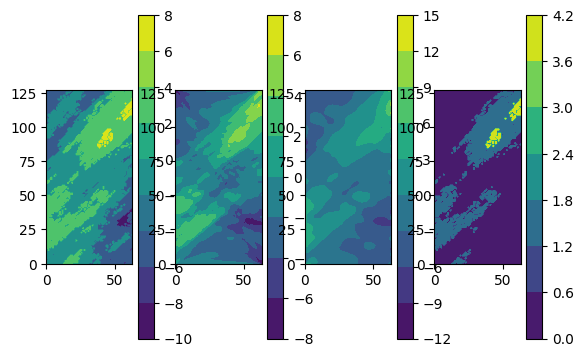

In [46]:
plt.subplot(1,4,1)
plt.contourf(x, z, utrue.reshape(64, 128).t())
plt.axis('image')
plt.colorbar()
plt.subplot(1,4,2)
plt.contourf(x, z, uhat.reshape(64, 128).t())
plt.axis('image')
plt.colorbar()
plt.subplot(1,4,3)
plt.contourf(x, z, uReg.reshape(64, 128).t())
plt.axis('image')
plt.colorbar()
plt.subplot(1,4,4)
plt.contourf(x, z, uR.detach().reshape(64, 128).t())
plt.axis('image')
plt.colorbar()

In [47]:
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # bottleneck layer
        self.bottleneck = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, out_channels, kernel_size=2, stride=2)
        )

    def forward(self, x):
        # Encoder
        x1 = self.encoder(x)

        # Bottleneck
        x2 = self.bottleneck(x1)

        # Decoder
        x3 = self.decoder(x2)

        return x3


class iNetRes(nn.Module):
    def __init__(self, forProb, nhid=64, nx=64, nz=128, niter=8):
        super(iNetRes, self).__init__()

        reg = nn.ModuleList()
        for i in range(niter):
            regi = UNet(in_channels=1, out_channels=1)
            reg.append(regi)

        self.reg = reg
        self.forProb = forProb
        self.niter = niter
        self.nx = nx
        self.nz = nz
        self.alpha = 0.01

    def forward(self, d):
        u = 1e-3 * self.forProb.adjoint(d)
        u = u.reshape(1, 1, self.nx, self.nz)

        for i in range(self.niter):
            Au = self.forProb(u)
            r = Au - d

            g_data = self.forProb.adjoint(r)
            Ag = self.forProb(g_data)
            mu = (Ag * r).mean() / (Ag * Ag).mean()

            g_data = g_data.reshape(u.shape[0], u.shape[1], u.shape[2], u.shape[3])
            u = u - mu * g_data

            s = self.reg[i](u)
            u = u - self.alpha * s

        return u


In [50]:
# training the network
net = iNetRes(tomo)
print('Number of parameters = ',sum([p.numel() for p in net.parameters()]))

optim = Adam(net.parameters(), lr=1e-3)

n_epochs = 150

for i in range(n_epochs):

  optim.zero_grad()
  uR = net(dn)

  loss = F.mse_loss(uR.view(-1), utrue.view(-1))/F.mse_loss(torch.zeros_like(utrue), utrue)
  print('%3d    %3.2e'%(i, loss))
  loss.backward()
  torch.nn.utils.clip_grad_norm_(parameters=net.parameters(), max_norm=0.6, norm_type=2.0)
  optim.step()

Number of parameters =  2959880
  0    3.00e-01
  1    2.99e-01
  2    2.95e-01
  3    2.92e-01
  4    2.78e-01
  5    2.82e-01
  6    2.81e-01
  7    2.80e-01
  8    2.75e-01
  9    2.72e-01
 10    2.71e-01
 11    2.63e-01
 12    2.60e-01
 13    2.53e-01
 14    2.47e-01
 15    2.42e-01
 16    2.41e-01
 17    2.31e-01
 18    2.32e-01
 19    2.31e-01
 20    2.20e-01
 21    2.23e-01
 22    2.22e-01
 23    2.11e-01
 24    2.12e-01
 25    2.06e-01
 26    2.01e-01
 27    2.10e-01
 28    2.07e-01
 29    1.95e-01
 30    2.01e-01
 31    1.98e-01
 32    1.92e-01
 33    1.92e-01
 34    1.86e-01
 35    1.86e-01
 36    1.86e-01
 37    1.81e-01
 38    1.78e-01
 39    1.77e-01
 40    1.77e-01
 41    1.70e-01
 42    1.67e-01
 43    1.68e-01
 44    1.69e-01
 45    1.70e-01
 46    1.64e-01
 47    1.65e-01
 48    1.61e-01
 49    1.58e-01
 50    1.56e-01
 51    1.53e-01
 52    1.54e-01
 53    1.52e-01
 54    1.52e-01
 55    1.50e-01
 56    1.49e-01
 57    1.51e-01
 58    1.45e-01
 59    1.42e-01
 60    1

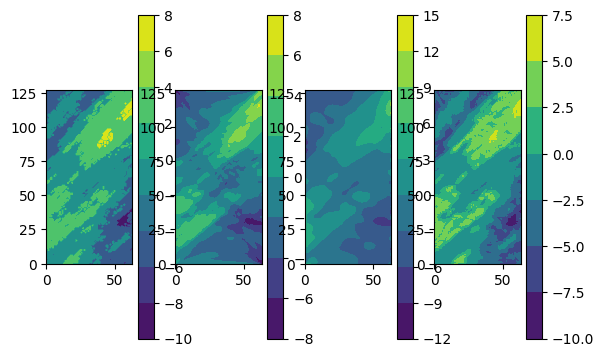

In [51]:
plt.subplot(1,4,1)
plt.contourf(x, z, utrue.reshape(64, 128).t())
plt.axis('image')
plt.colorbar()
plt.subplot(1,4,2)
plt.contourf(x, z, uhat.reshape(64, 128).t())
plt.axis('image')
plt.colorbar()
plt.subplot(1,4,3)
plt.contourf(x, z, uReg.reshape(64, 128).t())
plt.axis('image')
plt.colorbar()
plt.subplot(1,4,4)
plt.contourf(x, z, uR.detach().reshape(64, 128).t())
plt.axis('image')
plt.colorbar()